# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for AdvXResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
__version__

'1.0.55.dev0'

# 6D image test

In [4]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [5]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [9]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [6]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

## Overfit dataset with 1108 classes

In [10]:
#df = pd.read_csv('train_sorted.csv', index_col=0)

In [12]:
#df.iloc[777,0]

'HEPG2-01/Plate3/M12_s1'

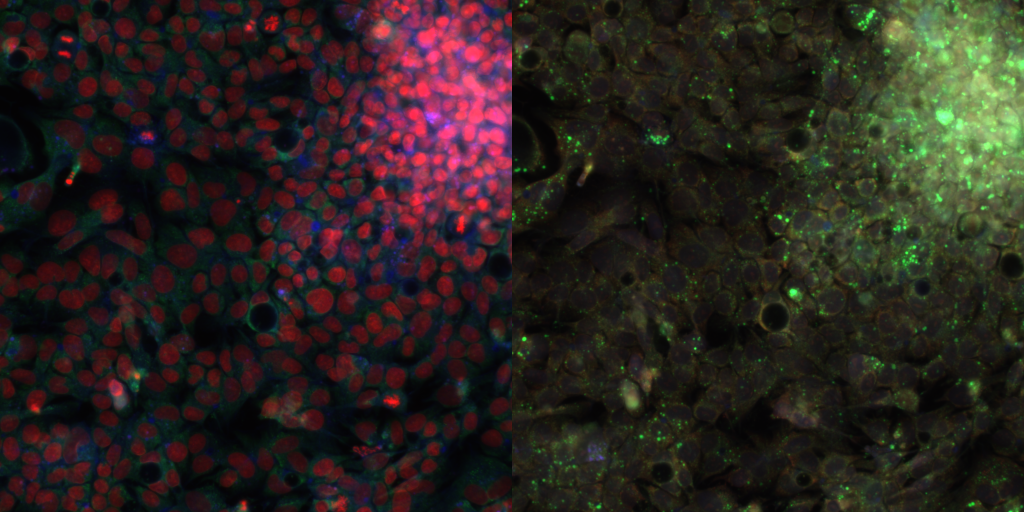

In [13]:
#open_image_6D('train/'+df.iloc[777,0])

In [15]:
#df.head()

,path,sirna
0,HEPG2-01/Plate1/B03_s1,513
1,HEPG2-01/Plate1/B04_s1,840
2,HEPG2-01/Plate1/B05_s1,1020
3,HEPG2-01/Plate1/B06_s1,254
4,HEPG2-01/Plate1/B07_s1,144


In [16]:
#df_subset = pd.concat([df.loc[df.sirna == i].head(1) for i in range(1108+1)], ignore_index=True)

## Adversarial test dataset

### Adversarial test dataset setup

In [61]:
df_train = pd.read_csv('train.csv')

In [62]:
df_train.head()

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144


In [63]:
df_train.experiment.unique(), len(df_train.experiment.unique())

(array(['HEPG2-01', 'HEPG2-02', 'HEPG2-03', 'HEPG2-04', 'HEPG2-05', 'HEPG2-06', 'HEPG2-07', 'HUVEC-01', 'HUVEC-02',
        'HUVEC-03', 'HUVEC-04', 'HUVEC-05', 'HUVEC-06', 'HUVEC-07', 'HUVEC-08', 'HUVEC-09', 'HUVEC-10', 'HUVEC-11',
        'HUVEC-12', 'HUVEC-13', 'HUVEC-14', 'HUVEC-15', 'HUVEC-16', 'RPE-01', 'RPE-02', 'RPE-03', 'RPE-04', 'RPE-05',
        'RPE-06', 'RPE-07', 'U2OS-01', 'U2OS-02', 'U2OS-03'], dtype=object),
 33)

In [64]:
experiments = ['HEPG2-01', 'HEPG2-02', 'HEPG2-03', # train
               'HUVEC-01', 'HUVEC-02', 'HUVEC-03', # train
               'RPE-01' #valid
              ]

In [65]:
# setup empty df
df = pd.DataFrame()
# generate path without channel and image file suffix for open image function
df['path'] = df_train['experiment']+'/Plate'+df_train['plate'].apply(str)+'/'+df_train['well']+'_s1' #+'_w'


In [66]:
df['experiment'] = df_train['experiment']

In [67]:
df['sirna'] = df_train['sirna']

In [68]:
df['multi'] = df_train['experiment'].apply(lambda x: x.split('/')[0])+' '+df_train['sirna'].apply(lambda x: str(x))


In [69]:
df.head()

,path,experiment,sirna,multi
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144


In [70]:
# filter for experiments
df = df[df['experiment'].isin(experiments)]

In [71]:
# get rows/images per experiment
[len(df[df['experiment'] == x]) for x in experiments]

[1106, 1106, 1108, 1108, 1108, 1108, 1108]

In [72]:
df.tail()

,path,experiment,sirna,multi
26541,RPE-01/Plate4/O19_s1,RPE-01,832,RPE-01 832
26542,RPE-01/Plate4/O20_s1,RPE-01,773,RPE-01 773
26543,RPE-01/Plate4/O21_s1,RPE-01,200,RPE-01 200
26544,RPE-01/Plate4/O22_s1,RPE-01,725,RPE-01 725
26545,RPE-01/Plate4/O23_s1,RPE-01,318,RPE-01 318


In [73]:
df['valid'] = 0

In [74]:
# set valid dataset
df.loc[df['experiment'] == 'RPE-01','valid'] = 1

In [75]:
df.head()

,path,experiment,sirna,multi,valid
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513,0
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840,0
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020,0
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254,0
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144,0


In [76]:
df.tail()

,path,experiment,sirna,multi,valid
26541,RPE-01/Plate4/O19_s1,RPE-01,832,RPE-01 832,1
26542,RPE-01/Plate4/O20_s1,RPE-01,773,RPE-01 773,1
26543,RPE-01/Plate4/O21_s1,RPE-01,200,RPE-01 200,1
26544,RPE-01/Plate4/O22_s1,RPE-01,725,RPE-01 725,1
26545,RPE-01/Plate4/O23_s1,RPE-01,318,RPE-01 318,1


In [77]:
# get rows/images per experiment
[len(df[df['experiment'] == x]) for x in experiments]

[1106, 1106, 1108, 1108, 1108, 1108, 1108]

In [78]:
df.to_csv('df_adversarial_test_dataset.csv')

### Dataset parameters adversarial test

In [9]:
df = pd.read_csv('df_adversarial_test_dataset.csv', index_col=0)

In [ ]:
#sz = 512
#sz = 256
sz = 96

In [ ]:
#bs = 8*4 # 512x512
bs = 8*80 # 4*5*2*2 # 96x96 --> 7203MiB /  7952MiB
#bs = 8*4*4 # 256x256

In [55]:
sz, bs

128

### Basic dataset

In [82]:
data = (ImageList6D.from_df(df, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3) #, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .transform(size=sz)
        .databunch(bs=bs))

In [83]:
data

ImageDataBunch;

Train: LabelList (6644 items)
x: ImageList6D
Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (1108 items)
x: ImageList6D
Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96)
y: CategoryList
1084,415,890,360,500
Path: train;

Test: None

In [84]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [85]:
data.batch_size

640

In [86]:
data.train_ds[0]

(Image6D (6, 96, 96), Category 513)

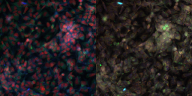

In [87]:
data.train_ds[0][0]

### Adversarial dataset

In [11]:
data_a = (ImageList6D.from_df(df, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .transform(size=sz)
        .databunch(bs=bs))

In [12]:
data_a

ImageDataBunch;

Train: LabelList (6644 items)
x: ImageList6D
Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (1108 items)
x: ImageList6D
Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96),Image6D (6, 96, 96)
y: MultiCategoryList
1084,415,890,360,500
Path: train;

Test: None

In [13]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1114, 1114, ['HEPG2-02', 'HEPG2-03', 'HUVEC-01', 'HUVEC-02', 'HUVEC-03'])

In [14]:
# CAUTION: Only 1108 siRNAs + 6 different experiments!

In [15]:
data_a.batch_size

640

In [16]:
data_a.train_ds[0]

(Image6D (6, 96, 96), MultiCategory HEPG2-01;513)

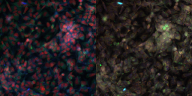

In [17]:
data_a.train_ds[0][0]

## Full dataset

### Full dataset setup

In [9]:
df_train = pd.read_csv('train.csv')

In [10]:
df_train.head()

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144


In [11]:
df_train.experiment.unique(), len(df_train.experiment.unique())

(array(['HEPG2-01', 'HEPG2-02', 'HEPG2-03', 'HEPG2-04', 'HEPG2-05', 'HEPG2-06', 'HEPG2-07', 'HUVEC-01', 'HUVEC-02',
        'HUVEC-03', 'HUVEC-04', 'HUVEC-05', 'HUVEC-06', 'HUVEC-07', 'HUVEC-08', 'HUVEC-09', 'HUVEC-10', 'HUVEC-11',
        'HUVEC-12', 'HUVEC-13', 'HUVEC-14', 'HUVEC-15', 'HUVEC-16', 'RPE-01', 'RPE-02', 'RPE-03', 'RPE-04', 'RPE-05',
        'RPE-06', 'RPE-07', 'U2OS-01', 'U2OS-02', 'U2OS-03'], dtype=object),
 33)

In [22]:
experiments = ['HEPG2-01', 'HEPG2-02', 'HEPG2-03', 'HEPG2-04', 'HEPG2-05', 'HEPG2-06', 'HEPG2-07', 
               'HUVEC-01', 'HUVEC-02', 'HUVEC-03', 'HUVEC-04', 'HUVEC-05', 'HUVEC-06', 'HUVEC-07', 
               'HUVEC-08', 'HUVEC-09', 'HUVEC-10', 'HUVEC-11', 'HUVEC-12', 'HUVEC-13', 'HUVEC-14', 
               'HUVEC-15', 'HUVEC-16', 
               'RPE-01', 'RPE-02', 'RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07', # train
               'U2OS-01', 'U2OS-02', 'U2OS-03' #valid
              ]

In [23]:
# setup empty df
df = pd.DataFrame()
# generate path without channel and image file suffix for open image function
df['path'] = df_train['experiment']+'/Plate'+df_train['plate'].apply(str)+'/'+df_train['well']+'_s1' #+'_w'


In [24]:
df['experiment'] = df_train['experiment']

In [25]:
df['sirna'] = df_train['sirna']

In [26]:
df['multi'] = df_train['experiment'].apply(lambda x: x.split('/')[0])+' '+df_train['sirna'].apply(lambda x: str(x))


In [27]:
df.head()

,path,experiment,sirna,multi
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144


In [28]:
# filter for experiments
df = df[df['experiment'].isin(experiments)]

In [29]:
# get rows/images per experiment
[len(df[df['experiment'] == x]) for x in experiments]

[1106,
 1106,
 1108,
 1108,
 1108,
 1108,
 1106,
 1108,
 1108,
 1108,
 1108,
 1108,
 1107,
 1107,
 1108,
 1108,
 1108,
 1108,
 1108,
 1102,
 1090,
 1094,
 1108,
 1108,
 1108,
 1108,
 1107,
 1108,
 1106,
 1108,
 1108,
 1108,
 1108]

In [31]:
df.tail()

,path,experiment,sirna,multi
36510,U2OS-03/Plate4/O19_s1,U2OS-03,103,U2OS-03 103
36511,U2OS-03/Plate4/O20_s1,U2OS-03,202,U2OS-03 202
36512,U2OS-03/Plate4/O21_s1,U2OS-03,824,U2OS-03 824
36513,U2OS-03/Plate4/O22_s1,U2OS-03,328,U2OS-03 328
36514,U2OS-03/Plate4/O23_s1,U2OS-03,509,U2OS-03 509


In [32]:
df['valid'] = 0

In [33]:
# set valid dataset 'U2OS-01', 'U2OS-02', 'U2OS-03'
for c in ['U2OS-01', 'U2OS-02', 'U2OS-03']:
    df.loc[df['experiment'] == c,'valid'] = 1

In [34]:
df.head()

,path,experiment,sirna,multi,valid
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513,0
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840,0
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020,0
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254,0
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144,0


In [35]:
df.valid.mean()

0.09103108311652745

In [36]:
df.tail()

,path,experiment,sirna,multi,valid
36510,U2OS-03/Plate4/O19_s1,U2OS-03,103,U2OS-03 103,1
36511,U2OS-03/Plate4/O20_s1,U2OS-03,202,U2OS-03 202,1
36512,U2OS-03/Plate4/O21_s1,U2OS-03,824,U2OS-03 824,1
36513,U2OS-03/Plate4/O22_s1,U2OS-03,328,U2OS-03 328,1
36514,U2OS-03/Plate4/O23_s1,U2OS-03,509,U2OS-03 509,1


In [37]:
# get rows/images per experiment
[len(df[df['experiment'] == x]) for x in experiments]

[1106,
 1106,
 1108,
 1108,
 1108,
 1108,
 1106,
 1108,
 1108,
 1108,
 1108,
 1108,
 1107,
 1107,
 1108,
 1108,
 1108,
 1108,
 1108,
 1102,
 1090,
 1094,
 1108,
 1108,
 1108,
 1108,
 1107,
 1108,
 1106,
 1108,
 1108,
 1108,
 1108]

In [38]:
df.to_csv('df_full_dataset.csv')

### Full test dataset setup

In [5]:
df_test = pd.read_csv('test.csv')

In [6]:
df_test.head()

,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07


In [7]:
df_test.experiment.unique(), len(df_test.experiment.unique())

(array(['HEPG2-08', 'HEPG2-09', 'HEPG2-10', 'HEPG2-11', 'HUVEC-17', 'HUVEC-18', 'HUVEC-19', 'HUVEC-20', 'HUVEC-21',
        'HUVEC-22', 'HUVEC-23', 'HUVEC-24', 'RPE-08', 'RPE-09', 'RPE-10', 'RPE-11', 'U2OS-04', 'U2OS-05'], dtype=object),
 18)

In [8]:
experiments = ['HEPG2-08', 'HEPG2-09', 'HEPG2-10', 'HEPG2-11', 'HUVEC-17', 'HUVEC-18', 'HUVEC-19', 'HUVEC-20', 'HUVEC-21',
        'HUVEC-22', 'HUVEC-23', 'HUVEC-24', 'RPE-08', 'RPE-09', 'RPE-10', 'RPE-11', 'U2OS-04', 'U2OS-05']

In [9]:
# setup empty df
df = pd.DataFrame()
# generate path without channel and image file suffix for open image function
df['path'] = df_train['experiment']+'/Plate'+df_train['plate'].apply(str)+'/'+df_train['well']+'_s1' #+'_w'


In [10]:
df['experiment'] = df_train['experiment']

In [13]:
#df['sirna'] = df_train['sirna']

In [15]:
#df['multi'] = df_train['experiment'].apply(lambda x: x.split('/')[0])+' '+df_train['sirna'].apply(lambda x: str(x))


In [16]:
df.head()

,path,experiment
0,HEPG2-08/Plate1/B03_s1,HEPG2-08
1,HEPG2-08/Plate1/B04_s1,HEPG2-08
2,HEPG2-08/Plate1/B05_s1,HEPG2-08
3,HEPG2-08/Plate1/B06_s1,HEPG2-08
4,HEPG2-08/Plate1/B07_s1,HEPG2-08


In [17]:
# filter for experiments
df = df[df['experiment'].isin(experiments)]

In [18]:
# get rows/images per experiment
[len(df[df['experiment'] == x]) for x in experiments]

[1107,
 1108,
 1108,
 1106,
 1108,
 1107,
 1108,
 1108,
 1108,
 1108,
 1099,
 1100,
 1108,
 1107,
 1108,
 1094,
 1108,
 1097]

In [19]:
df.tail()

,path,experiment
19892,U2OS-05/Plate4/O19_s1,U2OS-05
19893,U2OS-05/Plate4/O20_s1,U2OS-05
19894,U2OS-05/Plate4/O21_s1,U2OS-05
19895,U2OS-05/Plate4/O22_s1,U2OS-05
19896,U2OS-05/Plate4/O23_s1,U2OS-05


In [22]:
df.to_csv('df_full_test_dataset.csv')

### Dataset parameters full dataset

In [7]:
df = pd.read_csv('df_full_dataset.csv', index_col=0)

In [8]:
## XResNet18
#sz = 512
##sz = 256 # Use this!
#sz = 96

## XResNet34
#sz = 512
sz = 256

In [9]:
## XResNet18
#bs = 8*4 # 512x512
#bs = 8*80 # 4*5*2*2 # 96x96 --> 7203MiB /  7952MiB
##bs = 8*4*4 # 256x256 --> ~7100MB # Use this!

## XResNet34
#bs = 8*4 # 256x256 --> 3687MiB /  7952MiB
bs = 8*7 # 256x256 --> 

In [10]:
sz, bs

(256, 56)

### Basic full dataset

In [11]:
data = (ImageList6D.from_df(df, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3) #, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .transform(size=sz) # !!!
        .databunch(bs=bs))

In [12]:
data

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
267,768,632,86,1051
Path: train;

Test: None

In [13]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [14]:
data.batch_size

56

In [15]:
data.train_ds[0]

(Image6D (6, 256, 256), Category 513)

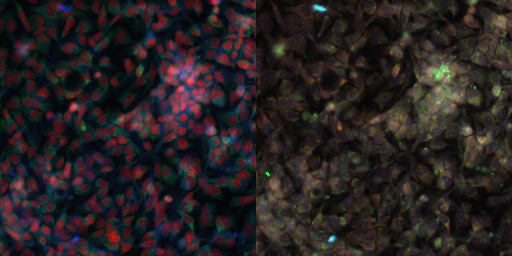

In [16]:
data.train_ds[0][0]

### Adversarial full dataset

In [19]:
data_a = (ImageList6D.from_df(df, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .transform(size=sz)
        .databunch(bs=bs))

In [20]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [21]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [28]:
#learn_a.data.classes[:1108]

In [29]:
learn_a.data.classes[1107]

NameError: name 'learn_a' is not defined

In [176]:
learn_a.data.classes[1107:1111]

['997', '998', '999', 'HEPG2-01', 'HEPG2-02', 'HEPG2-03']

In [174]:
learn_a.data.classes[1108:]

['HEPG2-01',
 'HEPG2-02',
 'HEPG2-03',
 'HEPG2-04',
 'HEPG2-05',
 'HEPG2-06',
 'HEPG2-07',
 'HUVEC-01',
 'HUVEC-02',
 'HUVEC-03',
 'HUVEC-04',
 'HUVEC-05',
 'HUVEC-06',
 'HUVEC-07',
 'HUVEC-08',
 'HUVEC-09',
 'HUVEC-10',
 'HUVEC-11',
 'HUVEC-12',
 'HUVEC-13',
 'HUVEC-14',
 'HUVEC-15',
 'HUVEC-16',
 'RPE-01',
 'RPE-02',
 'RPE-03',
 'RPE-04',
 'RPE-05',
 'RPE-06',
 'RPE-07']

In [22]:
data_a.batch_size

128

In [23]:
data_a.train_ds[0]

(Image6D (6, 256, 256), MultiCategory HEPG2-01;513)

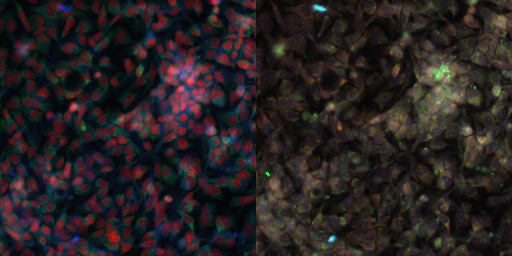

In [24]:
data_a.train_ds[0][0]

# Model setup

## XResNet setup

### XResNet18

In [68]:
xresnet18c = XResNet(1, [2,2,2 ,2], c_in=6, c_out=1108) #XResNet18!

In [69]:
#xresnet18c

In [70]:
xresnet18c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1108])

In [71]:
xresnet18c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

### XResNet34

In [21]:
xresnet34c = XResNet(1, [3,4,6 ,3], c_in=6, c_out=1108) #XResNet34!

In [22]:
#xresnet34c

In [23]:
xresnet34c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1108])

In [24]:
xresnet34c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

## AdvXResNetWO (no RevGrad) setup

**This should be equivalent to the XResNet and is only for testing!**

In [112]:
class AdvXResNetWO(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            #nn.Linear(block_szs[-1]*expansion, c_out),
            output(block_szs, expansion, c_out, c_out_a)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [113]:
class output(Module):
    def __init__(self, block_szs, expansion, c_out, c_out_a):
        self.c_out, self.c_out_a = c_out, c_out_a
        
        self.AAP = nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        self.lin = nn.Linear(block_szs[-1]*expansion, c_out)
        self.lin_a = nn.Linear(block_szs[-1]*expansion, c_out_a)
        #self.rg = RevGrad()
        
    def forward(self, x):
        x = self.AAP(x)
        x = self.flatten(x)
        
        #x = torch.cat((self.lin(x), self.lin_a(x)), dim=1)
        #return x # self.lin(x), self.lin_a(x)
        
        x1 = self.lin(x)
        x2 = self.lin_a(x) ### !!! ''''''
        
        return torch.cat((x1, x2), dim=1)

In [114]:
advxresnetwo18c = AdvXResNetWO(1, [2,2,2,2], c_out_a=data_a.c-1108)

In [115]:
#advxresnetwo18c

In [116]:
advxresnetwo18c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1138])

In [117]:
advxresnetwo18c(data_a.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1138])

## AdvXResNet setup

In [25]:
class AdvXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            #nn.Linear(block_szs[-1]*expansion, c_out),
            output_a(block_szs, expansion, c_out, c_out_a)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [26]:
# https://github.com/janfreyberg/pytorch-revgrad v0.1
from torch.autograd import Function

class RevGrad(Function):
    @staticmethod
    def forward(ctx, input_):
        ctx.save_for_backward(input_)
        output = input_
        return output

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        grad_input = None
        if ctx.needs_input_grad[0]:
            grad_input = -grad_output
        return grad_input


revgrad = RevGrad.apply

class RevGrad(Module):
    def __init__(self, *args, **kwargs):
        """
        A gradient reversal layer.
        This layer has no parameters, and simply reverses the gradient
        in the backward pass.
        """

        super().__init__(*args, **kwargs)

    def forward(self, input_):
        return revgrad(input_)

In [27]:
class output_a(Module):
    def __init__(self, block_szs, expansion, c_out, c_out_a):
        self.c_out, self.c_out_a = c_out, c_out_a
        
        self.AAP = nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        self.lin = nn.Linear(block_szs[-1]*expansion, c_out)
        self.lin_a = nn.Linear(block_szs[-1]*expansion, c_out_a)
        self.rg = RevGrad()
        
    def forward(self, x):
        x = self.AAP(x)
        x = self.flatten(x)
        
        #x = torch.cat((self.lin(x), self.lin_a(x)), dim=1)
        #return x # self.lin(x), self.lin_a(x)
        
        x1 = self.lin(x)
        x2 = self.rg(self.lin_a(x))
        
        return torch.cat((x1, x2), dim=1)

In [28]:
advxresnet18c = AdvXResNet(1, [2,2,2,2], c_out_a=data_a.c-1108)

In [29]:
#advxresnet18c

In [30]:
advxresnet18c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1138])

In [31]:
advxresnet18c(data_a.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1138])

# Training adversarial test

## Training XResNet18

In [178]:
learn = Learner(data, xresnet18c, metrics=[accuracy]) # accuracy_thresh for MultiCategory

In [179]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [180]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Traceback (most recent call last):
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [94]:
learn.fit_one_cycle(10, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,7.459019,25.993080,0.000903,00:43
1,7.222211,41.320942,0.000903,00:42
2,7.078152,29.473171,0.001805,00:42
3,6.984354,11.016136,0.000903,00:42
4,6.902228,8.907523,0.000000,00:42
5,6.823132,8.455572,0.000903,00:42
6,6.728204,7.775639,0.002708,00:42
7,6.619603,7.602205,0.000000,00:42
8,6.501002,7.357343,0.001805,00:42
9,6.396495,7.387090,0.002708,00:43


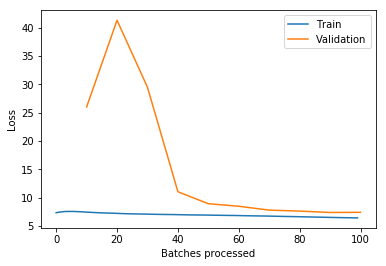

In [95]:
learn.recorder.plot_losses()

In [96]:
learn.fit_one_cycle(20, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.974137,7.277861,0.001805,00:42
1,5.947115,7.209591,0.000000,00:42
2,5.912396,7.070403,0.004513,00:42
3,5.896284,10.827129,0.000000,00:42
4,5.870542,18.417852,0.000903,00:42
5,5.848984,11.793490,0.001805,00:42
6,5.779848,31.825054,0.000903,00:42
7,5.659586,23.950548,0.000903,00:42
8,5.502620,11.982000,0.002708,00:43
9,5.319695,9.091652,0.000000,00:42


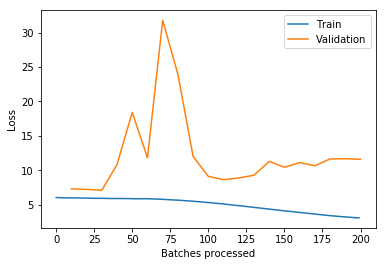

In [97]:
learn.recorder.plot_losses()

In [98]:
learn.save('basic_xresnet18c_20190705_e30', return_path=True)

PosixPath('train/models/basic_xresnet18c_20190705_e30.pth')

In [99]:
learn.load('basic_xresnet18c_20190705_e30');

In [100]:
learn.fit_one_cycle(20, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,2.311974,11.483765,0.000903,00:43
1,2.298169,11.694131,0.001805,00:42
2,2.281096,11.338844,0.000903,00:42
3,2.280507,13.596828,0.000000,00:42
4,2.378415,17.375462,0.000903,00:42
5,2.505867,40.284092,0.001805,00:42
6,2.464993,24.735479,0.001805,00:43
7,2.331183,17.115152,0.000903,00:42
8,2.123381,18.433132,0.000903,00:42
9,1.894492,17.167610,0.000903,00:42


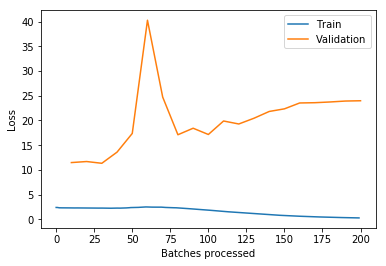

In [101]:
learn.recorder.plot_losses()

In [102]:
learn.save('basic_xresnet18c_20190705_e50', return_path=True)

PosixPath('train/models/basic_xresnet18c_20190705_e50.pth')

In [103]:
learn.load('basic_xresnet18c_20190705_e50');

In [104]:
learn.fit_one_cycle(50, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.010873,24.074787,0.002708,00:42
1,0.010837,24.088430,0.002708,00:42
2,0.010704,24.037733,0.002708,00:42
3,0.010992,24.101919,0.002708,00:42
4,0.011063,24.045446,0.002708,00:42
5,0.011070,24.126358,0.002708,00:43
6,0.010713,24.152552,0.002708,00:43
7,0.010447,24.117931,0.002708,00:42
8,0.010282,24.135052,0.002708,00:42
9,0.009899,24.171572,0.002708,00:42


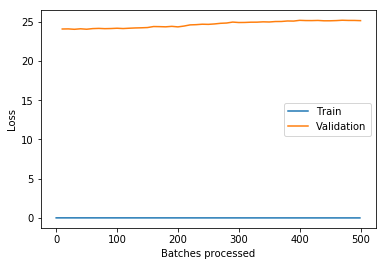

In [105]:
learn.recorder.plot_losses()

In [106]:
learn.save('basic_xresnet18c_20190705_e100', return_path=True)

PosixPath('train/models/basic_xresnet18c_20190705_e100.pth')

In [107]:
learn.load('basic_xresnet18c_20190705_e100');

## Training AdvXResNet18

In [122]:
??accuracy

In [123]:
??accuracy_thresh

In [127]:
torch.zeros((640,1114))[:,:1108].shape

torch.Size([640, 1108])

In [132]:
torch.randn((640,1114)).argmax(dim=-1).view(640,-1).shape

torch.Size([640, 1])

In [32]:
# based on the accuracy function but only use the first 1108 outputs
def accuracy_a(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input[:,:1108].argmax(dim=-1).view(n,-1)
    #targs = targs.view(n,-1)
    targs = targs[:,:1108].argmax(dim=-1).view(n,-1) # VERY LIKELY NEEDED!
    return (input==targs).float().mean()

In [200]:
# CUSTOM LOSS FUNCTION (CE + BCE)

In [31]:
BCEWithLogitsFlat()

FlattenedLoss of BCEWithLogitsLoss()

In [145]:
CrossEntropyFlat()

FlattenedLoss of CrossEntropyLoss()

In [146]:
??CrossEntropyFlat

In [147]:
??FlattenedLoss

In [ ]:
#def CrossEntropyFlat_a(*args, axis:int=-1, **kwargs):
#    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
#    return FlattenedLoss(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)

In [32]:
# VERSION 1: With only CE for targets
class FlattenedLoss_a(FlattenedLoss):
    def __init__(sefl, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __repr__(self): return f"FlattenedLoss of {self.func} ADVERSARIAL"
    
    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        input = input[:,:1108].transpose(self.axis,-1).contiguous()
        #target = target[:1108].transpose(self.axis,-1).contiguous() # not needed
        
        #target = target[:,:1108].transpose(self.axis,-1).contiguous()
        target = target[:,:1108].argmax(dim=-1)#.view(n,-1)
        target = target.transpose(self.axis,-1).contiguous()
        
        if self.floatify: target = target.float()
        input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        return self.func.__call__(input, target.view(-1), **kwargs)

In [33]:
CrossEntropyFlat_a = FlattenedLoss_a(nn.CrossEntropyLoss)

In [39]:
??nn.CrossEntropyLoss

In [42]:
??nn.BCEWithLogitsLoss

In [ ]:
# https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348/8?u=micpie

In [54]:
# VERSION 2: With CE for targets and BCE for adversarial targets.
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b.view(-1), target_b.view(-1), **kwargs) # for BCEWithLogitsLoss input and target needs to flattend
        return loss_a + loss_b

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target[:,:1108].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = BCEWithLogitsLoss
        input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        target_b = target[:,1108:].float().transpose(self.axis,-1).contiguous() # argmax needed to get the class
        ## testing func_a
        #input_b = torch.tensor([0.])
        #target_b = torch.tensor([0.])
        
        
        # not needed?
        #if self.floatify: target = target.float()
        #input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        
        #loss_a = self.func_a.__call__(input_a, target_a.view(-1), **kwargs) # get ird of .view(-1) ???
        #loss_b = self.func_b.__call__(input_b, target_b.view(-1), **kwargs)
        #return loss_a + loss_b
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [55]:
CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.BCEWithLogitsLoss)

In [172]:
# from https://pytorch.org/docs/stable/nn.html#crossentropyloss
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)

In [173]:
input, target

(tensor([[ 0.3386, -0.2921,  0.1136,  1.6458,  1.1559],
         [ 0.9094,  0.0536, -0.2047, -1.3522, -0.4651],
         [ 0.8645,  0.1525, -0.2763, -0.6551,  0.2494]], requires_grad=True),
 tensor([0, 2, 0]))

In [192]:
input = torch.randn(64,1114)
target = torch.empty(64, dtype=torch.long).random_(1108) # 1114

In [193]:
input, target

(tensor([[ 0.5768,  0.6952,  1.3338,  ...,  0.6172, -1.0996,  0.6976],
         [-0.1325, -0.1642, -1.3513,  ..., -0.8540, -0.4540, -0.4733],
         [ 0.3013, -0.9823,  0.3419,  ..., -1.5684, -1.2513,  0.4486],
         ...,
         [-0.2425,  0.0888, -0.4191,  ...,  0.9868, -0.1609, -1.3338],
         [ 2.0453, -0.0065,  0.5420,  ..., -1.5234,  0.2518, -2.4483],
         [ 1.4299,  0.1111,  0.2148,  ..., -1.2499, -1.4942, -1.0675]]),
 tensor([ 470,   94,  934,  652,  292,  126,   10,  565,  613,  188,  203,  382,
          351, 1103,  507,  551,  698,  400,  214,  659,  796,  168,  674,  495,
         1095,  547,  229,  998,  336,  999, 1012, 1063,  848,  782,  435,  575,
          397,  154,  262,  276,  211,  514,  725,  981,  777,  352,  648,  331,
          179,  512,  196,  126,  191, 1077,  960,  160,  716,  520,  162,  256,
          537,  604,  991,  249]))

In [194]:
input.shape, target.shape

(torch.Size([64, 1114]), torch.Size([64]))

In [171]:
?nn.CrossEntropyLoss

In [195]:
CrossEntropyFlat()(input=input, target=target)

tensor(7.3770)

In [196]:
input[:,:1108].shape

torch.Size([64, 1108])

In [197]:
target[:1108]

tensor([ 470,   94,  934,  652,  292,  126,   10,  565,  613,  188,  203,  382,
         351, 1103,  507,  551,  698,  400,  214,  659,  796,  168,  674,  495,
        1095,  547,  229,  998,  336,  999, 1012, 1063,  848,  782,  435,  575,
         397,  154,  262,  276,  211,  514,  725,  981,  777,  352,  648,  331,
         179,  512,  196,  126,  191, 1077,  960,  160,  716,  520,  162,  256,
         537,  604,  991,  249])

In [198]:
CrossEntropyFlat_a(input=input, target=target)

tensor(7.3711)

In [71]:
learn_a = Learner(data_a, advxresnet18c, metrics=[accuracy_a]) # [accuracy_thresh]

In [72]:
learn_a.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [73]:
#learn_a.loss_func = CrossEntropyFlat_a

In [74]:
learn_a.loss_func = CombinedLoss

In [75]:
learn_a.loss_func

CombinedFlattenedLoss of CrossEntropyLoss() and BCEWithLogitsLoss()

In [61]:
# check CombinedLoss
learn_a.fit_one_cycle(1, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,9.196249,10.598640,0.000903,00:42


In [62]:
# check CombinedLoss
learn_a.fit_one_cycle(10, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,13.982795,15.361112,0.000903,00:42
1,39.503437,632.146545,0.000903,00:42
2,423.847321,1506.083618,0.000903,00:42
3,2285.368164,8317.464844,0.000903,00:42
4,6361.224121,21288.484375,0.000903,00:42
5,12434.820312,35022.300781,0.000903,00:42
6,19478.476562,24948.505859,0.000903,00:42
7,26401.845703,35091.539062,0.002708,00:42
8,32389.484375,41971.164062,0.000903,00:42
9,37121.597656,40311.734375,0.001805,00:42


In [63]:
# check CombinedLoss
learn_a.fit_one_cycle(10, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,55457.687500,50052.851562,0.000000,00:42
1,58262.808594,44141.105469,0.000903,00:42
2,65272.878906,46194.417969,0.000903,00:42
3,76926.914062,74661.804688,0.000903,00:42
4,91750.750000,68227.367188,0.000903,00:42
5,108580.039062,76092.929688,0.001805,00:42
6,125619.203125,93370.835938,0.001805,00:42
7,141315.984375,96102.250000,0.000903,00:42
8,154445.609375,125834.210938,0.000903,00:42
9,164757.578125,153826.796875,0.000000,00:42


In [76]:
# check CombinedLoss with gradient reversal
learn_a.fit_one_cycle(10, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,7.923415,23.379244,0.000903,00:42
1,7.617860,15.979762,0.000903,00:42
2,7.425261,17.091223,0.000000,00:42
3,7.273678,8.077251,0.000000,00:42
4,7.129583,8.144429,0.000903,00:42
5,6.976711,7.470587,0.001805,00:42
6,6.797374,7.809118,0.001805,00:42
7,6.603370,8.017282,0.000000,00:42
8,6.408947,8.391090,0.000903,00:42
9,6.233610,8.695848,0.000903,00:42


In [53]:
# check implementation with input_b and target_b set to 0
# should result in CE loss from below with around 7
learn_a.fit_one_cycle(1, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,7.737978,7.725513,0.001805,00:42


In [33]:
# CE+BCE seems to be quite high
learn_a.fit_one_cycle(1, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,130.964767,359.199646,0.000903,00:42


In [38]:
# only CE seems to be OK
learn_a.fit_one_cycle(1, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,7.554266,57.066174,0.000903,00:42


# Full training

## Training XResNet18

In [72]:
learn = Learner(data, xresnet18c, metrics=[accuracy]) # accuracy_thresh for MultiCategory

In [73]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### Training without data augmentation

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 9.12E-02


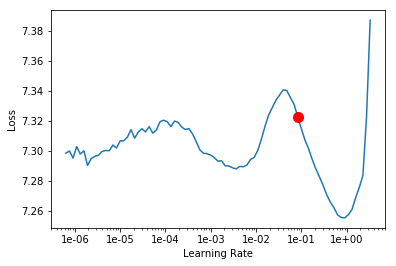

In [74]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [75]:
learn.fit_one_cycle(4, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,6.980312,7.234621,0.001504,02:55
1,6.890391,7.699031,0.002708,02:56
2,6.778417,7.019974,0.003008,02:56
3,6.668759,6.950327,0.002106,02:56


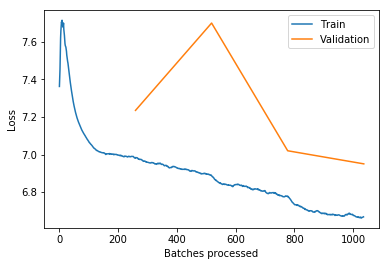

In [76]:
learn.recorder.plot_losses()

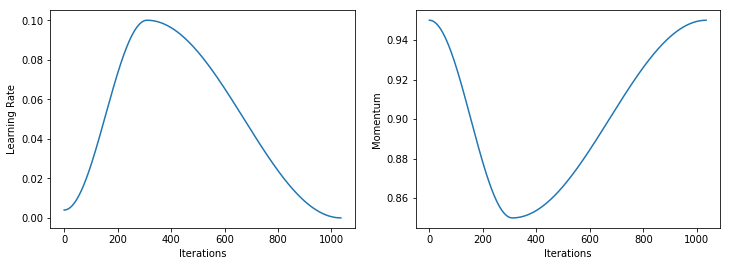

In [77]:
learn.recorder.plot_lr(show_moms=True)

In [80]:
learn.save('full_256x256_xresnet18c_e004_20190707', return_path=True)

PosixPath('train/models/full_256x256_xresnet18c_e004_20190707.pth')

In [81]:
learn.load('full_256x256_xresnet18c_e004_20190707');

In [82]:
learn.fit_one_cycle(8, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,6.663086,6.999198,0.002106,02:56
1,6.719995,7.292919,0.001805,02:57
2,6.696443,7.265489,0.002708,02:55
3,6.651142,7.386690,0.002708,02:55
4,6.569816,6.977228,0.000602,02:56
5,6.508230,8.813704,0.003309,02:56
6,6.403554,7.827834,0.003610,02:56
7,6.333396,8.356259,0.003610,02:57


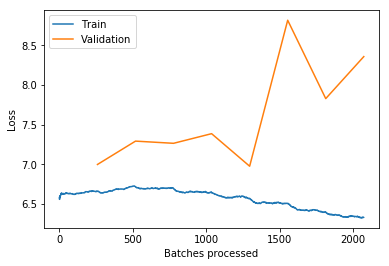

In [83]:
learn.recorder.plot_losses()

In [84]:
learn.save('full_256x256_xresnet18c_e012_20190707', return_path=True)

PosixPath('train/models/full_256x256_xresnet18c_e012_20190707.pth')

In [85]:
learn.load('full_256x256_xresnet18c_e012_20190707');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 1.10E-03


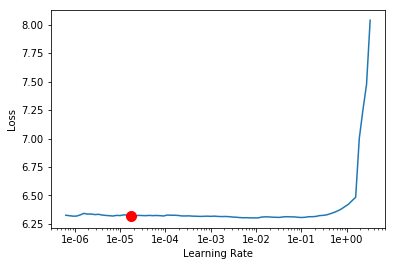

In [86]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [87]:
learn.fit_one_cycle(8, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.323745,8.724754,0.002106,02:56
1,6.349061,8.922752,0.003309,02:56
2,6.327325,8.435763,0.003008,02:57
3,6.315948,8.946115,0.002106,02:56
4,6.278501,9.147357,0.002407,02:56
5,6.244705,9.105495,0.001504,02:57
6,6.209341,9.518442,0.001203,02:57
7,6.192421,9.708562,0.001805,02:57


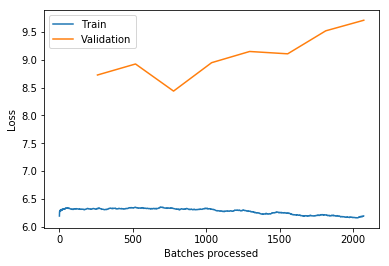

In [88]:
learn.recorder.plot_losses()

In [89]:
learn.save('full_256x256_xresnet18c_e020_20190707', return_path=True)

PosixPath('train/models/full_256x256_xresnet18c_e020_20190707.pth')

In [90]:
learn.load('full_256x256_xresnet18c_e020_20190707');

## Training AdvXResNetWO18

### Training without BCE for experiments, RevGrad, and data augmentation

In [ ]:
# https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348/8?u=micpie

In [118]:
# VERSION 2: With CE for targets and BCE for adversarial targets.
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b.view(-1), target_b.view(-1), **kwargs) # for BCEWithLogitsLoss input and target needs to flattend
        return loss_a + loss_b

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target[:,:1108].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = BCEWithLogitsLoss
        #input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        #target_b = target[:,1108:].float().transpose(self.axis,-1).contiguous() # argmax needed to get the class
        ## testing func_a
        input_b = torch.tensor([0.])
        target_b = torch.tensor([0.])
        
        
        # not needed?
        #if self.floatify: target = target.float()
        #input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        
        #loss_a = self.func_a.__call__(input_a, target_a.view(-1), **kwargs) # get ird of .view(-1) ???
        #loss_b = self.func_b.__call__(input_b, target_b.view(-1), **kwargs)
        #return loss_a + loss_b
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [119]:
CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.BCEWithLogitsLoss)

In [120]:
learn_a = Learner(data_a, advxresnetwo18c, metrics=[accuracy_a]) # [accuracy_thresh]

In [121]:
learn_a.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [123]:
learn_a.loss_func = CombinedLoss

In [124]:
learn_a.loss_func

CombinedFlattenedLoss of CrossEntropyLoss() and BCEWithLogitsLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 7.59E-02


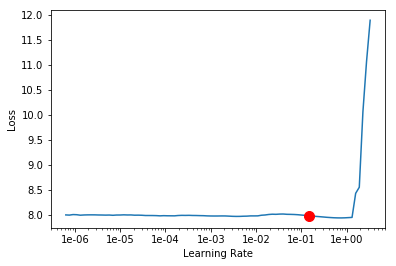

In [125]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [137]:
learn_a.fit_one_cycle(4, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,7.757938,7.751678,0.000903,02:57
1,7.747877,7.922280,0.000301,02:58
2,7.597215,7.695932,0.001504,02:57
3,7.461022,7.767500,0.000903,02:57


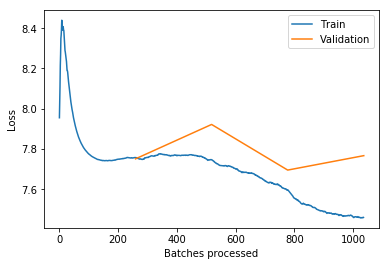

In [138]:
learn_a.recorder.plot_losses()

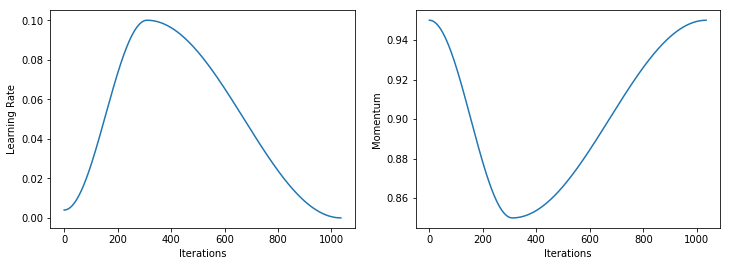

In [139]:
learn_a.recorder.plot_lr(show_moms=True)

In [140]:
learn_a.save('full_256x256_advxresnetwo18c_e004_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnetwo18c_e004_20190707.pth')

In [141]:
learn_a.load('full_256x256_advxresnetwo18c_e004_20190707');

/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type AdvXResNetWO. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type output. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [142]:
learn_a.fit_one_cycle(8, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,7.408655,7.725993,0.000903,02:55
1,7.437669,8.915384,0.002708,02:54
2,7.407766,9.366285,0.000602,02:54
3,7.350338,7.709887,0.002407,02:55
4,7.229413,8.522513,0.001203,02:55
5,7.126061,8.565467,0.001504,02:55
6,6.962488,8.661859,0.002106,02:54
7,6.903204,8.436142,0.002407,02:54


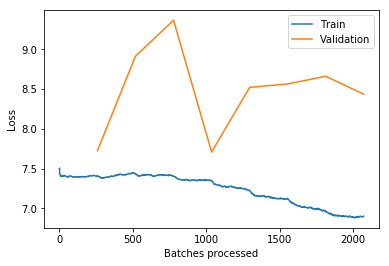

In [143]:
learn_a.recorder.plot_losses()

In [144]:
learn_a.save('full_256x256_advxresnetwo18c_e012_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnetwo18c_e012_20190707.pth')

In [145]:
learn_a.load('full_256x256_advxresnetwo18c_e012_20190707');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-08


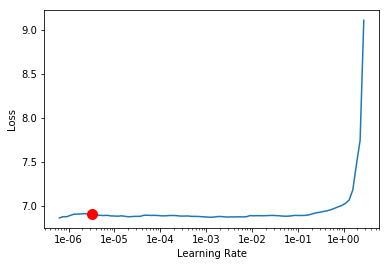

In [146]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [147]:
learn_a.fit_one_cycle(8, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_a,time
0,6.855404,8.658580,0.002708,02:54
1,6.897952,8.445541,0.001203,02:55
2,6.877154,8.557212,0.002106,02:54
3,6.809771,8.583638,0.002106,02:56
4,6.770384,8.577003,0.002106,02:55
5,6.705697,8.497263,0.002106,02:56
6,6.653091,8.464309,0.001805,02:56
7,6.625593,8.354959,0.003008,02:55


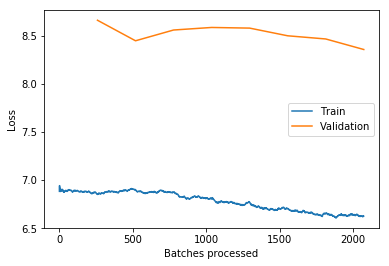

In [148]:
learn_a.recorder.plot_losses()

In [149]:
learn_a.save('full_256x256_advxresnetwo18c_e020_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnetwo18c_e020_20190707.pth')

In [150]:
learn_a.load('full_256x256_advxresnetwo18c_e020_20190707');

### Training with BCE for experiments without RevGrad and data augmentation

In [ ]:
# https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348/8?u=micpie

In [151]:
# VERSION 2: With CE for targets and BCE for adversarial targets.
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b.view(-1), target_b.view(-1), **kwargs) # for BCEWithLogitsLoss input and target needs to flattend
        return loss_a + loss_b

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target[:,:1108].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = BCEWithLogitsLoss
        input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        target_b = target[:,1108:].float().transpose(self.axis,-1).contiguous() # argmax needed to get the class
        ## testing func_a
        #input_b = torch.tensor([0.])
        #target_b = torch.tensor([0.])
        
        
        # not needed?
        #if self.floatify: target = target.float()
        #input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        
        #loss_a = self.func_a.__call__(input_a, target_a.view(-1), **kwargs) # get ird of .view(-1) ???
        #loss_b = self.func_b.__call__(input_b, target_b.view(-1), **kwargs)
        #return loss_a + loss_b
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [152]:
CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.BCEWithLogitsLoss)

In [153]:
learn_a = Learner(data_a, advxresnetwo18c, metrics=[accuracy_a]) # [accuracy_thresh]

In [154]:
learn_a.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [155]:
learn_a.loss_func = CombinedLoss

In [156]:
learn_a.loss_func

CombinedFlattenedLoss of CrossEntropyLoss() and BCEWithLogitsLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-01
Min loss divided by 10: 3.02E-02


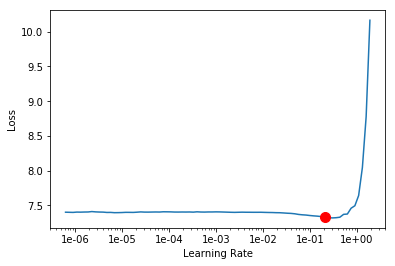

In [157]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [158]:
learn_a.fit_one_cycle(4, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,6.935268,7.031931,0.001203,02:54
1,6.874189,7.405357,0.003008,02:55
2,6.715700,7.814358,0.001504,02:54
3,6.563831,7.967864,0.001805,02:54


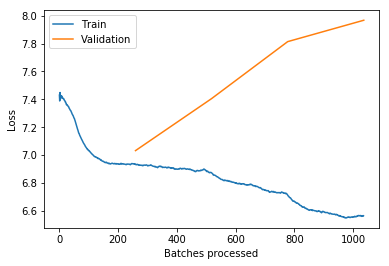

In [159]:
learn_a.recorder.plot_losses()

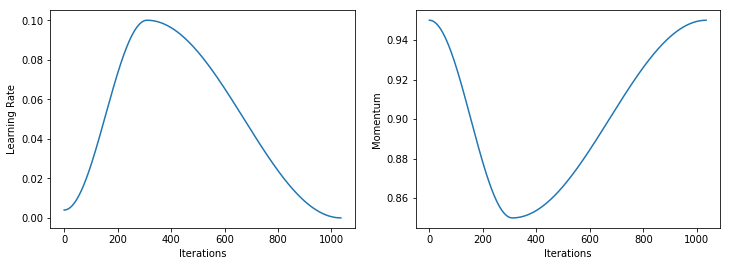

In [160]:
learn_a.recorder.plot_lr(show_moms=True)

In [161]:
learn_a.save('full_256x256_advxresnetwo18c_combinedlossworevgrad_e004_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnetwo18c_combinedlossworevgrad_e004_20190707.pth')

In [162]:
learn_a.load('full_256x256_advxresnetwo18c_combinedlossworevgrad_e004_20190707');

In [163]:
learn_a.fit_one_cycle(8, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy_a,time
0,6.572107,8.409187,0.001504,02:55
1,6.712270,8.468645,0.002407,02:54
2,6.737731,8.888977,0.001805,02:54
3,6.687127,7.063810,0.001805,02:54
4,6.579979,10.214423,0.001805,02:55
5,6.426106,7.495962,0.003008,02:54
6,6.296865,8.128562,0.001805,02:54
7,6.196167,8.715221,0.001805,02:54


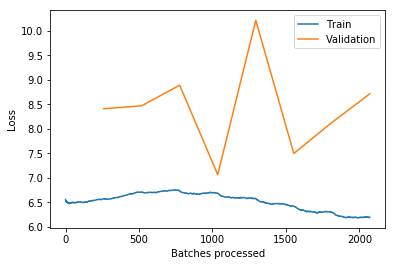

In [164]:
learn_a.recorder.plot_losses()

In [165]:
learn_a.save('full_256x256_advxresnetwo18c_combinedlossworevgrad_e012_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnetwo18c_combinedlossworevgrad_e012_20190707.pth')

In [166]:
learn_a.load('full_256x256_advxresnetwo18c_combinedlossworevgrad_e012_20190707');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.20E-04


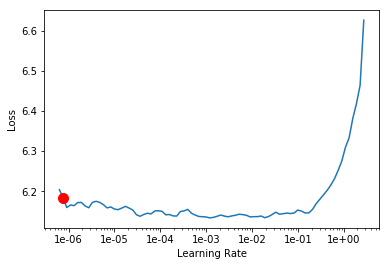

In [167]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [168]:
learn_a.fit_one_cycle(8, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_a,time
0,6.166449,8.521882,0.001805,02:55
1,6.177361,9.365395,0.001805,02:56
2,6.185185,8.449814,0.001805,02:55
3,6.152841,9.445106,0.001805,02:55
4,6.099848,9.478143,0.001504,02:56
5,6.054246,9.035382,0.001203,02:55
6,5.978526,8.850858,0.001203,02:55
7,5.971536,9.020541,0.001805,02:55


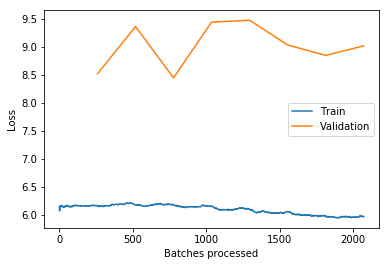

In [169]:
learn_a.recorder.plot_losses()

In [170]:
learn_a.save('full_256x256_advxresnetwo18c_combinedlossworevgrad_e020_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnetwo18c_combinedlossworevgrad_e020_20190707.pth')

In [171]:
learn_a.load('full_256x256_advxresnetwo18c_combinedlossworevgrad_e020_20190707');

### Verify categories

In [172]:
learn_a.data.train_ds[0]

(Image6D (6, 256, 256), MultiCategory HEPG2-01;513)

In [173]:
learn_a.data.train_ds[0][1]

MultiCategory HEPG2-01;513

In [175]:
learn_a.data.classes[:1108]

['0',
 '1',
 '10',
 '100',
 '1000',
 '1001',
 '1002',
 '1003',
 '1004',
 '1005',
 '1006',
 '1007',
 '1008',
 '1009',
 '101',
 '1010',
 '1011',
 '1012',
 '1013',
 '1014',
 '1015',
 '1016',
 '1017',
 '1018',
 '1019',
 '102',
 '1020',
 '1021',
 '1022',
 '1023',
 '1024',
 '1025',
 '1026',
 '1027',
 '1028',
 '1029',
 '103',
 '1030',
 '1031',
 '1032',
 '1033',
 '1034',
 '1035',
 '1036',
 '1037',
 '1038',
 '1039',
 '104',
 '1040',
 '1041',
 '1042',
 '1043',
 '1044',
 '1045',
 '1046',
 '1047',
 '1048',
 '1049',
 '105',
 '1050',
 '1051',
 '1052',
 '1053',
 '1054',
 '1055',
 '1056',
 '1057',
 '1058',
 '1059',
 '106',
 '1060',
 '1061',
 '1062',
 '1063',
 '1064',
 '1065',
 '1066',
 '1067',
 '1068',
 '1069',
 '107',
 '1070',
 '1071',
 '1072',
 '1073',
 '1074',
 '1075',
 '1076',
 '1077',
 '1078',
 '1079',
 '108',
 '1080',
 '1081',
 '1082',
 '1083',
 '1084',
 '1085',
 '1086',
 '1087',
 '1088',
 '1089',
 '109',
 '1090',
 '1091',
 '1092',
 '1093',
 '1094',
 '1095',
 '1096',
 '1097',
 '1098',
 '1099',
 

In [177]:
learn_a.data.classes[1108]

'HEPG2-01'

In [176]:
learn_a.data.classes[1105:1111]

['997', '998', '999', 'HEPG2-01', 'HEPG2-02', 'HEPG2-03']

In [174]:
learn_a.data.classes[1108:]

['HEPG2-01',
 'HEPG2-02',
 'HEPG2-03',
 'HEPG2-04',
 'HEPG2-05',
 'HEPG2-06',
 'HEPG2-07',
 'HUVEC-01',
 'HUVEC-02',
 'HUVEC-03',
 'HUVEC-04',
 'HUVEC-05',
 'HUVEC-06',
 'HUVEC-07',
 'HUVEC-08',
 'HUVEC-09',
 'HUVEC-10',
 'HUVEC-11',
 'HUVEC-12',
 'HUVEC-13',
 'HUVEC-14',
 'HUVEC-15',
 'HUVEC-16',
 'RPE-01',
 'RPE-02',
 'RPE-03',
 'RPE-04',
 'RPE-05',
 'RPE-06',
 'RPE-07']

## Training AdvXResNet18

### Training with RevGrad and without data augmentation

In [ ]:
# https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348/8?u=micpie

In [188]:
# VERSION 2: With CE for targets and BCE for adversarial targets.
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b.view(-1), target_b.view(-1), **kwargs) # for BCEWithLogitsLoss input and target needs to flattend
        return loss_a + loss_b

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target[:,:1108].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = BCEWithLogitsLoss
        input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        target_b = target[:,1108:].float().transpose(self.axis,-1).contiguous() # argmax needed to get the class
        ## testing func_a
        #input_b = torch.tensor([0.])
        #target_b = torch.tensor([0.])
        
        
        # not needed?
        #if self.floatify: target = target.float()
        #input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        
        #loss_a = self.func_a.__call__(input_a, target_a.view(-1), **kwargs) # get ird of .view(-1) ???
        #loss_b = self.func_b.__call__(input_b, target_b.view(-1), **kwargs)
        #return loss_a + loss_b
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [189]:
CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.BCEWithLogitsLoss)

In [190]:
learn_a = Learner(data_a, advxresnet18c, metrics=[accuracy_a]) # [accuracy_thresh]

In [191]:
learn_a.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [193]:
learn_a.loss_func = CombinedLoss

In [194]:
learn_a.loss_func

CombinedFlattenedLoss of CrossEntropyLoss() and BCEWithLogitsLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-07


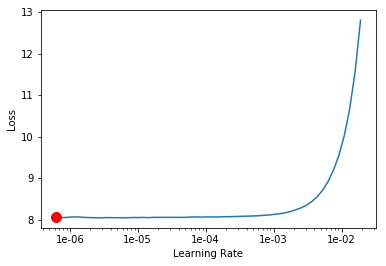

In [195]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [196]:
learn_a.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy_a,time
0,9.105832,9.866493,0.001805,02:54
1,17.003498,19.797211,0.002407,02:55
2,24.388481,26.116547,0.000903,02:55
3,26.374357,27.229073,0.001805,02:55


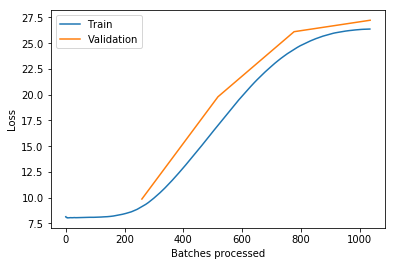

In [197]:
learn_a.recorder.plot_losses()

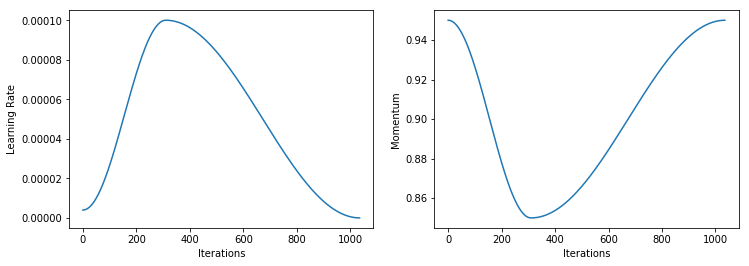

In [198]:
learn_a.recorder.plot_lr(show_moms=True)

In [199]:
learn_a.save('full_256x256_advxresnet18c_e004_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnet18c_e004_20190707.pth')

In [200]:
learn_a.load('full_256x256_advxresnet18c_e004_20190707');

/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RevGrad. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type AdvXResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type output_a. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [201]:
learn_a.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy_a,time
0,27.745287,28.953035,0.002106,02:54
1,35.182903,38.210327,0.000602,02:54
2,48.797432,50.709301,0.000903,02:54
3,63.882282,66.706490,0.001805,02:54
4,77.160904,78.816170,0.001203,02:53
5,87.080925,79.200317,0.000903,02:54
6,91.514648,83.907471,0.000301,02:54
7,92.426796,82.707382,0.000903,02:54


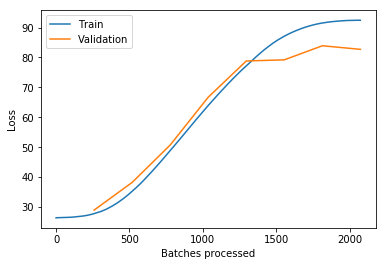

In [202]:
learn_a.recorder.plot_losses()

In [203]:
learn_a.save('full_256x256_advxresnet18c_e012_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnet18c_e012_20190707.pth')

In [204]:
learn_a.load('full_256x256_advxresnet18c_e012_20190707');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.31E-07


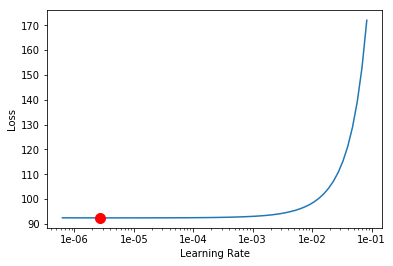

In [205]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [206]:
learn_a.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy_a,time
0,94.714859,83.941658,0.000903,02:55
1,107.276627,98.112526,0.000903,02:54
2,130.043503,120.468010,0.000903,02:55
3,154.149628,135.401047,0.000903,02:55
4,174.606934,155.977097,0.000903,02:55
5,188.305176,165.943634,0.000903,02:55
6,194.639725,173.716492,0.000903,02:55
7,196.014511,173.634583,0.000301,02:54


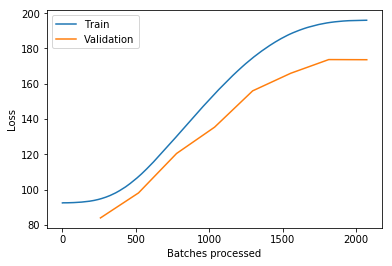

In [207]:
learn_a.recorder.plot_losses()

In [208]:
learn_a.save('full_256x256_advxresnet18c_e020_20190707', return_path=True)

PosixPath('train/models/full_256x256_advxresnet18c_e020_20190707.pth')

In [209]:
learn_a.load('full_256x256_advxresnet18c_e020_20190707');

### Training with Loss-scaling, RevGrad, and without data augmentation

In [ ]:
# https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348/8?u=micpie

In [33]:
# VERSION 3: With CE for targets and BCE for adversarial targets including domain loss scaling.
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, domain_loss_scale:float=1., **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)
        self.domain_loss_scale = domain_loss_scale

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b} (domain loss scale {self.domain_loss_scale})"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b.view(-1), target_b.view(-1), **kwargs) # for BCEWithLogitsLoss input and target needs to flattend
        loss = loss_a + self.domain_loss_scale * loss_b
        return loss

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target[:,:1108].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = BCEWithLogitsLoss
        input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        target_b = target[:,1108:].float().transpose(self.axis,-1).contiguous() # argmax needed to get the class
        ## testing func_a
        #input_b = torch.tensor([0.])
        #target_b = torch.tensor([0.])
        
        
        # not needed?
        #if self.floatify: target = target.float()
        #input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        
        #loss_a = self.func_a.__call__(input_a, target_a.view(-1), **kwargs) # get ird of .view(-1) ???
        #loss_b = self.func_b.__call__(input_b, target_b.view(-1), **kwargs)
        #return loss_a + loss_b
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [34]:
### NOT WORKING BUT NOT A GOOD IDEA AS THIS IS CALCULATED ON THE VALID DATASET!
# to get domain loss seperately
def domain_loss(input:Tensor, targs:Tensor, axis=-1)->Rank0Tensor:
    input_b = input[:,1108:].transpose(axis,-1).contiguous()
    target_b = targs[:,1108:].float().transpose(axis,-1).contiguous() # argmax needed to get the class
    loss_b = nn.BCEWithLogitsLoss(input_b.view(-1), target_b.view(-1)) # for BCEWithLogitsLoss
    return domain_loss


In [35]:
CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.BCEWithLogitsLoss)

In [36]:
learn_a = Learner(data_a, advxresnet18c, metrics=[domain_loss, accuracy_a]) # [accuracy_thresh]

In [37]:
learn_a.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [38]:
learn_a.loss_func = CombinedLoss

In [39]:
learn_a.loss_func

CombinedFlattenedLoss of CrossEntropyLoss() and BCEWithLogitsLoss() (domain loss scale 1.0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.31E-07


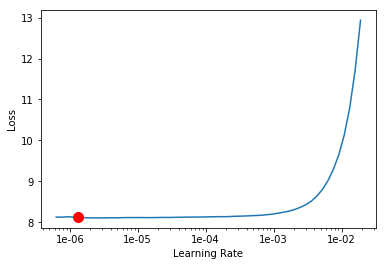

In [40]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [40]:
learn_a.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,domain_loss,accuracy_a,time


RuntimeError: bool value of Tensor with more than one value is ambiguous

In [ ]:
learn_a.recorder.plot_losses()

In [ ]:
learn_a.recorder.plot_lr(show_moms=True)

**Instead of trying domain loss scaling, try scaling the reversed gradients!**

## Training XResNet34

In [25]:
learn = Learner(data, xresnet34c, metrics=[accuracy]) # accuracy_thresh for MultiCategory

In [26]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### Training without data augmentation

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-04


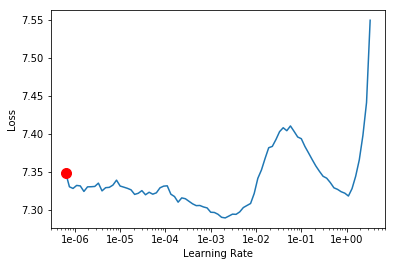

In [27]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [28]:
learn.fit_one_cycle(4, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.802806,7.269768,0.001805,04:47
1,6.568635,9.854970,0.001504,04:48
2,6.215524,10.592052,0.001504,04:48
3,5.874777,8.861199,0.002407,04:49


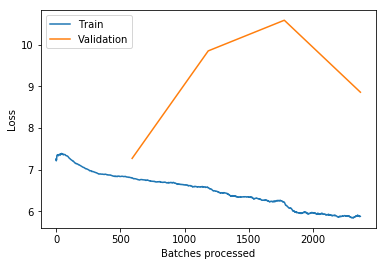

In [29]:
learn.recorder.plot_losses()

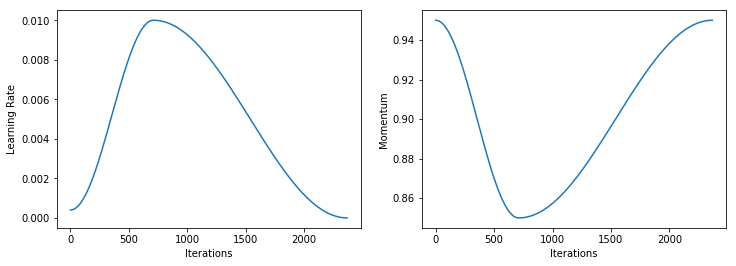

In [30]:
learn.recorder.plot_lr(show_moms=True)

In [31]:
learn.save('full_256x256_xresnet34c_e004_20190707', return_path=True)

PosixPath('train/models/full_256x256_xresnet34c_e004_20190707.pth')

In [32]:
learn.load('full_256x256_xresnet34c_e004_20190707');

In [33]:
learn.fit_one_cycle(8, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.832145,10.110272,0.003008,04:44
1,5.911980,10.990331,0.003008,04:48
2,5.688675,9.835064,0.001504,04:48
3,5.285640,9.464275,0.001805,04:48
4,4.822863,11.503415,0.002407,04:48


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):

KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_losses()

In [84]:
learn.save('full_256x256_xresnet34c_e012_20190707', return_path=True)

PosixPath('train/models/full_256x256_xresnet18c_e012_20190707.pth')

In [85]:
learn.load('full_256x256_xresnet34c_e012_20190707');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 1.10E-03


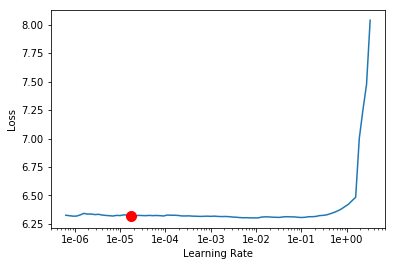

In [86]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [87]:
learn.fit_one_cycle(8, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.323745,8.724754,0.002106,02:56
1,6.349061,8.922752,0.003309,02:56
2,6.327325,8.435763,0.003008,02:57
3,6.315948,8.946115,0.002106,02:56
4,6.278501,9.147357,0.002407,02:56
5,6.244705,9.105495,0.001504,02:57
6,6.209341,9.518442,0.001203,02:57
7,6.192421,9.708562,0.001805,02:57


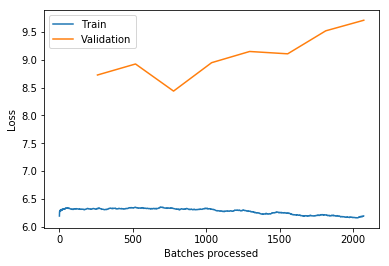

In [88]:
learn.recorder.plot_losses()

In [89]:
learn.save('full_256x256_xresnet34c_e020_20190707', return_path=True)

PosixPath('train/models/full_256x256_xresnet18c_e020_20190707.pth')

In [90]:
learn.load('full_256x256_xresnet34c_e020_20190707');

# MNIST test

In [18]:
path = untar_data(URLs.MNIST_SAMPLE)

In [19]:
data = ImageDataBunch.from_folder(path)

In [37]:
xresnet18c_10 = XResNet(1, [2,2,2 ,2], c_in=3, c_out=2)

In [38]:
xresnet18c_10

XResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [39]:
#models.resnet18()

In [ ]:
#learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [43]:
learn = Learner(data, xresnet18c_10, metrics=accuracy)

In [45]:
#learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 9.12E-02


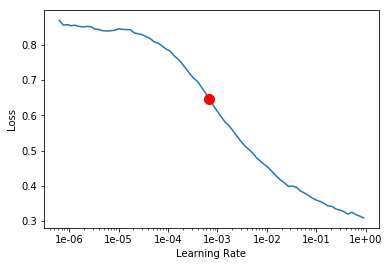

In [46]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [47]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.042963,0.152854,0.947988,00:03
1,0.017914,0.030530,0.988224,00:03
2,0.002760,0.005412,0.998037,00:03
3,0.000651,0.003466,0.998528,00:03


In [48]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.000725,0.003613,0.998528,00:03
1,0.000743,0.002509,0.999509,00:03
2,0.003659,0.060363,0.981354,00:03
3,0.003031,0.009353,0.998528,00:03
4,0.007357,0.008309,0.996075,00:03
5,0.008274,0.004722,0.998037,00:03
6,0.007049,0.013540,0.995093,00:03
7,0.001997,0.005054,0.998528,00:03
8,0.004338,0.007279,0.997547,00:03
9,0.001089,0.004564,0.998037,00:03


# Test predict

# Test submission